# Comparing ndmg branches

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Metadata

- This analysis uses the KKI2009 data <a href="http://mrneurodata.s3-website-us-east-1.amazonaws.com/KKI2009/" target="_blank">here</a>.
- Docker containers were used.
    - <a href="https://hub.docker.com/r/bids/ndmg/" target="_blank">master</a>
    - <a href="https://hub.docker.com/r/neurodata/m3r-release/" target="_blank">eric's branch</a>, build 0.1.1
- I used the outputs in 
    - **master**: /graphs/ (.edgelist)
    - **eric**: /dwi/roi-connectomes (csv)

## Plan

1. Eric
    - Load data as np array
    - Convert to adjacency matrix
2. Master
    - Load data as np array
    - Convert to adjacency matrixc
3. Define a function that takes a file location as input and returns an adjacency matrix as output
    - Check whether file location is from master or eric
    - Possibly needs to do different things depending on which branch it's taking data from
4. For each pair of supposedly-equivalent graphs, take the difference
5. Take the norm of the above
6. Plot this for every parcellation
7. Equivalent analysis for group-level data if individual analysis looks good

## Show where data is coming from

In [20]:
# Show the data I ran on in a tree structure. Ignore the \xa0\xa0's. Ran on 3 of the subjects from the KKI2009 dataset.
%system tree -d -L 3 /data/aloftus/pr-diff/KKI/KKI2009

['/data/aloftus/pr-diff/KKI/KKI2009',
 '├── sub-113',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '├── sub-127',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '└── sub-142',
 '    ├── ses-1',
 '    │\xa0\xa0 ├── anat',
 '    │\xa0\xa0 ├── dwi',
 '    │\xa0\xa0 └── func',
 '    └── ses-2',
 '        ├── anat',
 '        ├── dwi',
 '        └── func',
 '',
 '27 directories']

In [21]:
# Show eric's branch output dir
%system tree -d -L 2 /data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi

['/data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi',
 '├── fiber',
 '├── preproc',
 '├── registered',
 '├── roi-connectomes',
 '│\xa0\xa0 ├── aal_res-1x1x1',
 '│\xa0\xa0 ├── brodmann_res-1x1x1',
 '│\xa0\xa0 ├── CPAC200_res-1x1x1',
 '│\xa0\xa0 ├── desikan_res-1x1x1',
 '│\xa0\xa0 ├── DK_res-1x1x1',
 '│\xa0\xa0 ├── DS00071_res-1x1x1',
 '│\xa0\xa0 ├── DS00096_res-1x1x1',
 '│\xa0\xa0 ├── DS00108_res-1x1x1',
 '│\xa0\xa0 ├── DS00140_res-1x1x1',
 '│\xa0\xa0 ├── DS00195_res-1x1x1',
 '│\xa0\xa0 ├── DS00278_res-1x1x1',
 '│\xa0\xa0 ├── DS00350_res-1x1x1',
 '│\xa0\xa0 ├── DS00446_res-1x1x1',
 '│\xa0\xa0 ├── DS00583_res-1x1x1',
 '│\xa0\xa0 ├── DS00833_res-1x1x1',
 '│\xa0\xa0 ├── DS01216_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordcort-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordsub-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── hemispheric_res-1x1x1',
 '│\xa0\xa0 ├── JHU_res-1x1x1',
 '│\xa0\xa0 ├── slab1068_res-1x1x1',
 '│\xa0\xa0 ├── slab907_res-1x1x1',
 '│\xa0\xa0 └── tissue_res

In [22]:
# Show master branch output dir
%system tree -d -L 2 /data/aloftus/pr-diff/KKI/KKI-output/master/graphs

['/data/aloftus/pr-diff/KKI/KKI-output/master/graphs',
 '├── AAL',
 '├── CPAC200',
 '├── desikan',
 '├── Desikan2012',
 '├── DS00071',
 '├── DS00096',
 '├── DS00108',
 '├── DS00140',
 '├── DS00195',
 '├── DS00278',
 '├── DS00350',
 '├── DS00446',
 '├── DS00583',
 '├── DS00833',
 '├── DS01216',
 '├── DS01876',
 '├── DS03231',
 '├── DS06481',
 '├── DS16784',
 '├── DS72784',
 '├── HarvardOxford',
 '├── JHU',
 '├── slab1068',
 '├── slab907',
 '└── Talairach',
 '',
 '25 directories']

## Load data

### Grab output for one subject, one session

- Using Desikan, sub-113, ses-1 for testing purposes

In [89]:
# Save directory data
eric_graphs = r'/data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi/roi-connectomes/DK_res-1x1x1/'
master_graphs = r'/data/aloftus/pr-diff/KKI/KKI-output/master/graphs/Desikan2012/'

In [90]:
# Show output csv files. Arbitrarily using ses-1 of sub-113 as testing data.
print(os.listdir(eric_graphs), '\n')
print(os.listdir(master_graphs))

['sub-113_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-113_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-127_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-127_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv'] 

['sub-127_ses-1_dwi_Desikan2012.edgelist', 'sub-113_ses-2_dwi_Desikan2012.edgelist', 'sub-142_ses-1_dwi_Desikan2012.edgelist', 'sub-142_ses-2_dwi_Desikan2012.edgelist', 'sub-127_ses-2_dwi_Desikan2012.edgelist', 'sub-113_ses-1_dwi_Desikan2012.edgelist']


In [91]:
# Get networkX graph for eric's sub-113-ses-1-JHU
eric_edgelist_location = eric_graphs + 'sub-113_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv'
eric_nx = nx.read_weighted_edgelist(eric_edgelist_location, delimiter=',')

# Get networkX graph for masters's sub-113-ses-1-JHU
master_edgelist_location = master_graphs + 'sub-113_ses-1_dwi_Desikan2012.edgelist'
master_nx = nx.read_weighted_edgelist(master_edgelist_location, delimiter=' ')

In [92]:
# Quick look at the edgelists
pd.read_csv(eric_edgelist_location, delimiter=',', header=None).head()

,0,1,2
0,1,1,11916
1,1,2,575
2,1,3,38
3,1,36,4
4,1,37,1315


In [94]:
pd.read_csv(master_edgelist_location, header=None, delimiter=' ').head()

,0,1,2
0,1,34,3356
1,1,3,21
2,1,4,297
3,1,37,3542
4,1,6,1339


## quick info about these two graphs
---

In [95]:
# Node ordering was different
list(eric_nx.nodes()) == list(master_nx.nodes())

False

In [96]:
sorted(list(eric_nx.nodes())) == sorted(list(master_nx.nodes()))

True

In [97]:
eric_mat = nx.to_numpy_matrix(eric_nx, nodelist=sorted(list(master_nx.nodes())))
master_mat = nx.to_numpy_matrix(master_nx, nodelist=sorted(list(master_nx.nodes())))

In [98]:
eric_mat

matrix([[1.1916e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.9290e+04, 2.7210e+03, ..., 0.0000e+00, 0.0000e+00,
         2.1060e+03],
        [0.0000e+00, 2.7210e+03, 1.0079e+04, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 7.7710e+03, 1.4000e+01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.4000e+01, 3.2918e+04,
         0.0000e+00],
        [0.0000e+00, 2.1060e+03, 1.0000e+01, ..., 0.0000e+00, 0.0000e+00,
         6.2440e+03]])

In [100]:
np.fill_diagonal(eric_mat, 0)

In [101]:
eric_mat.astype(int)

matrix([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0, 2721, ...,    0,    0, 2106],
        [   0, 2721,    0, ...,    0,    0,   10],
        ...,
        [   0,    0,    0, ...,    0,   14,    0],
        [   0,    0,    0, ...,   14,    0,    0],
        [   0, 2106,   10, ...,    0,    0,    0]])

In [102]:
master_mat.astype(int)

matrix([[   0,   35,    0, ...,    0,    0,    0],
        [  35,    0, 1391, ...,    0,    0, 1134],
        [   0, 1391,    0, ...,    0,    0,    7],
        ...,
        [   0,    0,    0, ...,    0,   97,    0],
        [   0,    0,    0, ...,   97,    0,    0],
        [   0, 1134,    7, ...,    0,    0,    0]])

In [103]:
np.linalg.norm(eric_mat - master_mat, ord='fro')

38730.20074825329

## Resulting graphs

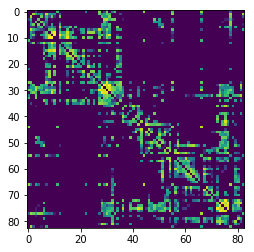

In [104]:
plt.imshow(np.log10(eric_mat + 1));

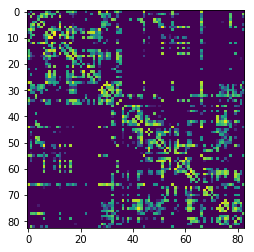

In [105]:
plt.imshow(np.log10(master_mat + 1));

## Function to load and compare graphs

Function should: 
1. Load a pair of graphs
2. Ensure they're in a consistent and sensible format (e.g., adjacency matrix)
3. Subtract one graph from the other
4. Take the norm of the result

In [106]:
# Will be useful for future analysis if needed
def load_and_compare(master: 'path', eric: 'path'):
    
    # Load a pair of graphs, convert to np array, remove diagonals in Eric's
    mast_nx = nx.read_weighted_edgelist(master)
    eric_nx = nx.read_weighted_edgelist(eric, delimiter=',')
    
    # Move each graph to adjacency matrix
    master_mat = nx.to_numpy_matrix(master_nx)
    eric_mat = nx.to_numpy_matrix(eric_nx)
    
    np.fill_diagonal(eric_mat, 0)
    
    # Subtract one graph from the other
    diff_mat = eric_mat - master_mat
    
    # Return a tuple of the master graph, eric graph, and norm of result
    return (master_mat, eric_mat, np.linalg.norm(eric_mat - master_mat, ord='fro'))